In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/ds1003_project

/content/drive/MyDrive/ds1003_project


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Data Preprocessing

In [ ]:
def import_excel_sheet(file_path, sheet_index, header_row, skip_footer=0):
    # Import the specified sheet
    data = pd.read_excel(
        file_path,
        sheet_name=sheet_index,  # Sheets are 0-indexed
        header=header_row,       # Set the index of the header row
        skipfooter=skip_footer   # Set the number of rows to skip at the end if needed
    )
    return data

# File path
file_path = 'US-Fixed-Income-Securities-Statistics-SIFMA.xlsx'

# Importing each sheet by index (skip the first sheet which is the table of contents)
outstanding = import_excel_sheet(file_path, sheet_index=1, header_row=7)
issuance = import_excel_sheet(file_path, sheet_index=2, header_row=7)
trading_volume = import_excel_sheet(file_path, sheet_index=3, header_row=7)

In [ ]:
def split_and_integrate_dataframe(df, table_prefix):
    # Find the indices of columns that contain "Unnamed"
    unnamed_indices = [index for index, col in enumerate(df.columns) if 'Unnamed' in col]

    # Define the suffixes for the table names
    table_suffixes = ['amount', 'percent_of_total', 'year_over_year_change', 'quarter_over_quarter_change']
    table_names = [f'{table_prefix}_{suffix}' for suffix in table_suffixes]

    # Dictionary to hold the tables
    tables = {}
    joined_table = pd.DataFrame()

    # Extract the tables using the unnamed_indices
    # Start with the index after the first 'Unnamed' column
    start_idx = unnamed_indices[0] + 1
    for i, end_idx in enumerate(unnamed_indices[1:], start=1):
        # The end index is the next 'Unnamed' column
        sub_table = df.iloc[:, start_idx:end_idx].dropna(axis=1, how='all')
        # Rename columns to include the suffix
        sub_table.columns = [f"{col}_{table_suffixes[i-1]}" for col in sub_table.columns]
        tables[table_names[i-1]] = sub_table
        joined_table = pd.concat([joined_table, sub_table], axis=1)
        start_idx = end_idx + 1

    # Handle the last table, which includes all remaining columns after the last 'Unnamed' column
    sub_table = df.iloc[:, start_idx:].dropna(axis=1, how='all')
    sub_table.columns = [f"{col}_{table_suffixes[-1]}" for col in sub_table.columns]
    tables[table_names[-1]] = sub_table
    joined_table = pd.concat([joined_table, sub_table], axis=1)

    return joined_table

# Function to remove dot and digits
def remove_dot_digits(column_name):
    import re
    # Regular expression to find ".<digits>" and replace it with nothing
    return re.sub(r'\.\d+', '', column_name)

integrated_outstanding = split_and_integrate_dataframe(outstanding, 'outstanding')
integrated_outstanding.rename(columns=lambda x: remove_dot_digits(x), inplace=True)

integrated_outstanding

In [ ]:
integrated_issuance = split_and_integrate_dataframe(issuance, 'outstanding')
integrated_issuance.rename(columns=lambda x: remove_dot_digits(x), inplace=True)
integrated_issuance

In [ ]:
integrated_trading_volume = split_and_integrate_dataframe(trading_volume, 'outstanding')
integrated_trading_volume.rename(columns=lambda x: remove_dot_digits(x), inplace=True)
integrated_trading_volume

In [ ]:
integrated_outstanding['Year'] = outstanding['Unnamed: 0'].astype(str)
integrated_issuance['Year'] = issuance['Unnamed: 0'].astype(str)
integrated_trading_volume['Year'] = trading_volume['Unnamed: 0'].astype(str)

In [ ]:
integrated_outstanding.to_csv('integrated_outstanding.csv', index=False)
integrated_issuance.to_csv('integrated_issuance.csv', index=False)
integrated_trading_volume.to_csv('integrated_trading_volume.csv', index=False)

In [ ]:
integrated_outstanding.info(), integrated_issuance.info(), integrated_trading_volume.info()

### Feature Engineer

integrated_outstanding: This dataset likely represents the total outstanding securities (like bonds or similar financial instruments) expressed in amounts (like total dollar value outstanding). Here, amount columns would represent the total value outstanding for each type of security (UST, MBS, etc.).

integrated_issuance: This dataset probably contains information on new issuances of securities. Here, amount would be the total value of new securities issued during the period.

integrated_trading_volume: This dataset should represent the total trading volume for each security type, where amount columns indicate the total volume of securities traded (in dollar terms or number of shares/units).

In [62]:
integrated_outstanding = pd.read_csv('integrated_outstanding.csv')
integrated_issuance = pd.read_csv('integrated_issuance.csv')
integrated_trading_volume = pd.read_csv('integrated_trading_volume.csv')

In [ ]:
integrated_outstanding.head()

In [ ]:
integrated_issuance.head()

In [ ]:
integrated_trading_volume.head()

#### Converting yield change to price change

In [ ]:
!pip install quandl

In [65]:
# Fetch Treasury yields from Quandl
import quandl
quandl.ApiConfig.api_key = 'WyVSVszQqJBDTFJrsjyw'

data = quandl.get('USTREASURY/YIELD', start_date='2013-01-01', end_date='2023-12-31')

# Assume a constant modified duration for the example, e.g., 10 years
# This value should ideally vary depending on the specific bond and current yield
duration = 9

# Calculate yield changes
yield_changes = data.diff()

# Convert yield changes to price changes using duration
# Yield changes are in percentages; convert them to decimals by dividing by 100
price_changes = -duration * (yield_changes / 100)

In [66]:
data

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,,,
2013-01-02,0.07,NaN,0.08,0.12,0.15,0.27,0.37,0.76,1.25,1.86,2.63,3.04
2013-01-03,0.06,NaN,0.08,0.12,0.15,0.27,0.40,0.81,1.31,1.92,2.70,3.12
2013-01-04,0.06,NaN,0.07,0.11,0.15,0.27,0.41,0.82,1.32,1.93,2.70,3.10
2013-01-07,0.05,NaN,0.07,0.11,0.15,0.27,0.41,0.82,1.31,1.92,2.70,3.10
2013-01-08,0.06,NaN,0.07,0.11,0.14,0.25,0.38,0.79,1.28,1.89,2.66,3.06
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,5.54,5.52,5.44,5.31,4.82,4.31,4.04,3.87,3.92,3.90,4.21,4.05
2023-12-26,5.53,5.52,5.45,5.28,4.83,4.26,4.05,3.89,3.91,3.89,4.20,4.04
2023-12-27,5.55,5.53,5.44,5.26,4.79,4.20,3.97,3.78,3.81,3.79,4.10,3.95


In [67]:
price_changes

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,,,
2013-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,0.0009,NaN,-0.0000,-0.0000,-0.0000,-0.0000,-0.0027,-0.0045,-0.0054,-0.0054,-0.0063,-0.0072
2013-01-04,-0.0000,NaN,0.0009,0.0009,-0.0000,-0.0000,-0.0009,-0.0009,-0.0009,-0.0009,-0.0000,0.0018
2013-01-07,0.0009,NaN,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0009,0.0009,-0.0000,-0.0000
2013-01-08,-0.0009,NaN,-0.0000,-0.0000,0.0009,0.0018,0.0027,0.0027,0.0027,0.0027,0.0036,0.0036
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,-0.0000,0.0009,-0.0018,-0.0000,0.0018,0.0018,0.0018,-0.0000,-0.0009,-0.0009,-0.0018,-0.0018
2023-12-26,0.0009,-0.0000,-0.0009,0.0027,-0.0009,0.0045,-0.0009,-0.0018,0.0009,0.0009,0.0009,0.0009
2023-12-27,-0.0018,-0.0009,0.0009,0.0018,0.0036,0.0054,0.0072,0.0099,0.0090,0.0090,0.0090,0.0081


In [68]:
price_changes.to_csv('ust_price_changes.csv', index = False)

In [69]:
# Calculate log returns of the price changes
price_changes['log_returns'] = np.log(1 + price_changes['10 YR'] / 100)

# Choose an appropriate rolling window size, for example, 22 trading days for a month
window_size = 25

# Calculate rolling standard deviation of log returns (realized volatility)
price_changes['realized_volatility'] = price_changes['log_returns'].rolling(window=window_size).std()

# Calculate the change in realized volatility from one period to the next
price_changes['realized_volatility_change'] = price_changes['realized_volatility'].diff()

# The first 'window_size - 1' entries will be NaN due to the rolling computation, so you may want to drop those
price_changes.dropna(subset=['realized_volatility_change'], inplace=True)

# Save the results to a new CSV file if needed
price_changes.to_csv('realized_volatility_changes.csv', index=True)

In [70]:
# Calculate the sign of the price changes using numpy for sign calculation
volume_df = integrated_trading_volume[['Year', 'UST_amount']]
price_changes_df = price_changes
price_changes_df['10 YR'].fillna(method='ffill', inplace=True)
price_changes_df['UST_amount'] = volume_df['UST_amount']
price_changes_df['UST_amount'].fillna(method='ffill', inplace=True)

In [71]:
# Analyze the trading volume data to understand its statistical properties
if 'Total_amount' in volume_df.columns:
    volume_stats = volume_df['Total_amount'].describe()
else:
    volume_stats = volume_df['UST_amount'].describe()  # Use another column if 'Total_amount' is not present

# Mean and standard deviation for the volume data
mean_volume = volume_stats['mean']
std_volume = volume_stats['std']

# Simulating trading volumes using a normal distribution
np.random.seed(42)  # Seed for reproducibility
simulated_volumes = np.random.normal(loc=mean_volume, scale=std_volume, size=len(price_changes_df))

# Ensure all simulated values are non-negative
simulated_volumes = np.maximum(simulated_volumes, 0)

# Add the simulated trading volumes to the price changes dataframe
price_changes_df['UST_amount'] = simulated_volumes

# Display the first few rows to verify the data
print(price_changes_df.head())

              1 MO  2 MO    3 MO    6 MO    1 YR    2 YR    3 YR    5 YR  \
Date                                                                       
2013-02-08 -0.0000   NaN -0.0000 -0.0000  0.0009 -0.0000 -0.0000 -0.0009   
2013-02-11 -0.0018   NaN -0.0018 -0.0009 -0.0009 -0.0018 -0.0009 -0.0009   
2013-02-12 -0.0027   NaN -0.0000 -0.0000  0.0009 -0.0018 -0.0009 -0.0027   
2013-02-13 -0.0009   NaN -0.0009 -0.0000 -0.0009 -0.0000 -0.0027 -0.0036   
2013-02-14 -0.0009   NaN -0.0009 -0.0009 -0.0009  0.0018  0.0018  0.0054   

              7 YR   10 YR   20 YR   30 YR  log_returns  realized_volatility  \
Date                                                                           
2013-02-08 -0.0000 -0.0000 -0.0009 -0.0000     0.000000             0.000028   
2013-02-11 -0.0009 -0.0000  0.0009  0.0009     0.000000             0.000028   
2013-02-12 -0.0027 -0.0027 -0.0027 -0.0027    -0.000027             0.000029   
2013-02-13 -0.0045 -0.0027 -0.0045 -0.0036    -0.000027            

#### Roll Measure


In [72]:
# Calculate daily squared price changes
price_changes_df['squared_changes'] = price_changes_df['10 YR'].diff().pow(2)

# Calculate daily Roll Measure
# Here, you might still consider a window to smooth out the measure, let's say using a rolling window of 1 day for daily measure
price_changes_df['Roll_Measure_Daily'] = price_changes_df['squared_changes'].rolling(window=window_size).sum() / (2 * price_changes_df['squared_changes'].rolling(window=1).count())

# Ensure the column is cleaned up to avoid NaN values
price_changes_df['Roll_Measure_Daily'].fillna(0, inplace=True)  # Or another appropriate method like forward fill

# Save or inspect your results
print(price_changes_df[['10 YR', 'Roll_Measure_Daily']].head(30))

             10 YR  Roll_Measure_Daily
Date                                  
2013-02-08 -0.0000            0.000000
2013-02-11 -0.0000            0.000000
2013-02-12 -0.0027            0.000000
2013-02-13 -0.0027            0.000000
2013-02-14  0.0045            0.000000
2013-02-15 -0.0009            0.000000
2013-02-19 -0.0018            0.000000
2013-02-20  0.0009            0.000000
2013-02-21  0.0027            0.000000
2013-02-22  0.0018            0.000000
2013-02-25  0.0081            0.000000
2013-02-26 -0.0000            0.000000
2013-02-27 -0.0027            0.000000
2013-02-28  0.0018            0.000000
2013-03-01  0.0027            0.000000
2013-03-04 -0.0018            0.000000
2013-03-05 -0.0018            0.000000
2013-03-06 -0.0045            0.000000
2013-03-07 -0.0045            0.000000
2013-03-08 -0.0054            0.000000
2013-03-11 -0.0009            0.000000
2013-03-12  0.0036            0.000000
2013-03-13 -0.0009            0.000000
2013-03-14 -0.0000       

##### roll measure using proxy

In [ ]:
def calculate_roll_measure(price_changes):
    # Calculate squared price changes
    squared_changes = price_changes.pow(2)
    # Calculate the Roll measure based on the formula for covariance approximation
    roll_measure = squared_changes.sum() / (2 * len(squared_changes.dropna()))
    return roll_measure

# Ensure that the 'price_changes' column is correctly referenced if it has a specific name in your CSV
# Example: price_changes = price_changes['column_name_of_price_changes']

# Ensure that the '10 YR' column is correctly referenced
ten_year_changes = price_changes['10 YR']

# Apply the Roll measure calculation quarterly
ust_roll_measures = ten_year_changes.resample('Q').apply(calculate_roll_measure)

print(ust_roll_measures)

Date
2013-03-31    0.000005
2013-06-30    0.000013
2013-09-30    0.000018
2013-12-31    0.000009
2014-03-31    0.000009
2014-06-30    0.000006
2014-09-30    0.000006
2014-12-31    0.000009
2015-03-31    0.000017
2015-06-30    0.000017
2015-09-30    0.000014
2015-12-31    0.000011
2016-03-31    0.000011
2016-06-30    0.000010
2016-09-30    0.000008
2016-12-31    0.000011
2017-03-31    0.000009
2017-06-30    0.000797
2017-09-30    0.000006
2017-12-31    0.000004
2018-03-31    0.000006
2018-06-30    0.000007
2018-09-30    0.000004
2018-12-31    0.000007
2019-03-31    0.000007
2019-06-30    0.000007
2019-09-30    0.000013
2019-12-31    0.000011
2020-03-31    0.000040
2020-06-30    0.000011
2020-09-30    0.000003
2020-12-31    0.000007
2021-03-31    0.000010
2021-06-30    0.000006
2021-09-30    0.000009
2021-12-31    0.000012
2022-03-31    0.000023
2022-06-30    0.000033
2022-09-30    0.000033
2022-12-31    0.000034
2023-03-31    0.000035
2023-06-30    0.000022
2023-09-30    0.000022
2023-1

In [ ]:
# Fetch Treasury yields from Quandl
data = quandl.get('USTREASURY/YIELD', start_date='2013-01-01', end_date='2023-12-31')

# Assuming conversion from yields to price changes is needed, simulate it (this part might need more refinement)
# Simple approach: invert the changes to simulate price-like behavior
price_changes = -data.diff()

# Calculate Roll measure directly based on the typical financial formula
def calculate_roll_measure(prices):
    squared_changes = prices.diff().pow(2)
    roll_measure = squared_changes.sum() / (2 * len(squared_changes.dropna()))
    return roll_measure

# Apply the Roll measure calculation quarterly
ust_roll_measures = price_changes.resample('Q').apply(calculate_roll_measure)

print(ust_roll_measures)

<ipython-input-26-b7ea7a5f8462>:11: RuntimeWarning: invalid value encountered in scalar divide
  roll_measure = squared_changes.sum() / (2 * len(squared_changes.dropna()))


                1 MO      2 MO      3 MO      6 MO      1 YR      2 YR  \
Date                                                                     
2013-03-31  0.000246       NaN  0.000152  0.000047  0.000038  0.000288   
2013-06-30  0.000140       NaN  0.000063  0.000055  0.000070  0.000300   
2013-09-30  0.000088       NaN  0.000114  0.000087  0.000116  0.000723   
2013-12-31  0.001348       NaN  0.000154  0.000297  0.000093  0.000342   
2014-03-31  0.000352       NaN  0.000116  0.000080  0.000090  0.000667   
2014-06-30  0.000102       NaN  0.000053  0.000044  0.000059  0.000279   
2014-09-30  0.000106       NaN  0.000116  0.000067  0.000092  0.000546   
2014-12-31  0.000178       NaN  0.000099  0.000217  0.000219  0.001083   
2015-03-31  0.000130       NaN  0.000122  0.000101  0.000371  0.002034   
2015-06-30  0.000110       NaN  0.000075  0.000162  0.000151  0.000866   
2015-09-30  0.000128       NaN  0.000364  0.000287  0.000471  0.001440   
2015-12-31  0.001238       NaN  0.0004

In [ ]:
# Fetch Treasury yields from Quandl
data = quandl.get('USTREASURY/YIELD', start_date='2013-01-01', end_date='2023-12-31')

# Assuming conversion from yields to price changes is needed, simulate it (this part might need more refinement)
# Simple approach: invert the changes to simulate price-like behavior
price_changes = -data.diff()

# Calculate Roll measure directly based on the typical financial formula
def calculate_roll_measure(prices):
    squared_changes = prices.diff().pow(2)
    roll_measure = squared_changes.sum() / (2 * len(squared_changes.dropna()))
    return roll_measure

# Apply the Roll measure calculation quarterly
ust_roll_measures = price_changes.resample('Q').apply(calculate_roll_measure)

print(ust_roll_measures)

In [ ]:
import quandl
# Set your Quandl API key
quandl.ApiConfig.api_key = 'WyVSVszQqJBDTFJrsjyw'

# Get the USTREASURY/YIELD data from Quandl
data = quandl.get('USTREASURY/YIELD')

# Filter the data to include only the range from 2013-2023
start_date = '2013-01-01'
end_date = '2023-12-31'
data = data.loc[start_date:end_date]

# Convert yields to approximate price changes
price_changes = -data.diff()

# Define a function to calculate the Roll measure for a DataFrame
def calculate_roll_measure(group):
    roll_measures = {}
    for column in group:
        # Skip non-numeric columns
        if not pd.api.types.is_numeric_dtype(group[column]):
            continue
        var_price_change = group[column].var()
        cov_price_change = group[column].cov(group[column].shift(-1))
        roll_measure = -2 * (cov_price_change ** 2) / var_price_change if var_price_change != 0 else None
        roll_measures[column] = roll_measure
    return pd.Series(roll_measures)

# Group by year and quarter and apply the Roll measure calculation
roll_measures_by_group = price_changes.groupby([price_changes.index.year, price_changes.index.quarter]).apply(calculate_roll_measure)

# Display the calculated Roll Measure for each maturity and group
print(roll_measures_by_group)

In [ ]:
# Calculate the change in total amount (proxy for price changes)
integrated_trading_volume['amount_change'] = integrated_trading_volume['Total_amount'].diff()

# Calculate variance of these changes
integrated_trading_volume['var_amount_change'] = integrated_trading_volume['amount_change'].rolling(window=2).var()

# Calculate covariance of consecutive changes (we shift to align the previous change with the current)
integrated_trading_volume['cov_amount_changes'] = integrated_trading_volume['amount_change'].rolling(window=2).cov(integrated_trading_volume['amount_change'].shift(-1))

# Calculate the Roll Measure using amount changes
integrated_trading_volume['roll_measure'] = -((integrated_trading_volume['cov_amount_changes']) / (2 * integrated_trading_volume['var_amount_change']))

# Display the calculated Roll Measure to check results
print(integrated_trading_volume[['Year', 'roll_measure']].dropna())

                   Year  roll_measure
2                  2015     -0.307030
3                  2016      0.635134
4                  2017      0.517910
5                  2018     -0.189762
6                  2019      0.385592
7                  2020     -1.444732
8                  2021     -0.368899
9                  2022      2.388787
17                 3Q22     -0.362420
18                 4Q22     -1.689748
19                 1Q23      0.762097
20                 2Q23      0.215769
21                 3Q23     -0.200080
22                 4Q23     -0.468257
27  2023-05-31 00:00:00      0.265281
28  2023-06-30 00:00:00      0.143442
29  2023-07-31 00:00:00     -0.696304
30  2023-08-31 00:00:00      0.356447
31  2023-09-30 00:00:00      0.344424
32  2023-10-31 00:00:00     -0.365204
33  2023-11-30 00:00:00      3.533503
34  2023-12-31 00:00:00      0.894580
35  2024-01-31 00:00:00      0.348657
36  2024-02-29 00:00:00     -0.122851


In [205]:
price_changes_df.to_csv('aaa.csv')

#### Kyles lambda

In [73]:
price_changes_df['Sign_10YR'] = price_changes_df['10 YR'].apply(np.sign)

# Calculate the rolling volume-weighted price impact and price difference for '1 YR'
price_changes_df['Volume_Weighted_10YR'] = (price_changes_df['Sign_10YR'] * price_changes_df['UST_amount']).rolling(window=window_size).sum()
price_changes_df['Price_Difference_10YR'] = price_changes_df['10 YR'].rolling(window=window_size).apply(lambda x: x.iloc[-1] - x.iloc[0])

# Compute Kyle's Lambda for '1 YR'
price_changes_df['Kyle_Lambda_10YR'] = price_changes_df['Price_Difference_10YR'] / price_changes_df['Volume_Weighted_10YR']

# Show the results with Kyle's Lambda calculations
price_changes_df[['10 YR', 'Sign_10YR', 'Volume_Weighted_10YR', 'Price_Difference_10YR', 'Kyle_Lambda_10YR']].head(50)


,10 YR,Sign_10YR,Volume_Weighted_10YR,Price_Difference_10YR,Kyle_Lambda_10YR
Date,,,,,
2013-02-08,-0.0000,0.0,NaN,NaN,NaN
2013-02-11,-0.0000,0.0,NaN,NaN,NaN
2013-02-12,-0.0027,-1.0,NaN,NaN,NaN
2013-02-13,-0.0027,-1.0,NaN,NaN,NaN
2013-02-14,0.0045,1.0,NaN,NaN,NaN
2013-02-15,-0.0009,-1.0,NaN,NaN,NaN
2013-02-19,-0.0018,-1.0,NaN,NaN,NaN
2013-02-20,0.0009,1.0,NaN,NaN,NaN
2013-02-21,0.0027,1.0,NaN,NaN,NaN


#### kyles lambda previous code

In [ ]:
# Assuming you have a DataFrame `df_trading` from 'integrated_trading_volume.csv' loaded
# df_trading = pd.read_csv('path_to_integrated_trading_volume.csv')

# You need to prepare both data sources to ensure they are aligned; this might involve setting datetime indices,
# resampling to common intervals, and merging the data frames. This is
# Extract the year part from the 'Year' column
integrated_trading_volume['Year'] = integrated_trading_volume['Year'].str.extract('(\d{4})')

# Convert the 'Year' column to datetime format
integrated_trading_volume['date'] = pd.to_datetime(integrated_trading_volume['Year'])

# Assuming 'data' comes with a DateTime index from Quandl
data['date'] = pd.to_datetime(data.index)

integrated_trading_volume.sort_values('date', inplace=True)
data.sort_values('date', inplace=True)
integrated_trading_volume.dropna(subset=['date'], inplace=True)
data.dropna(subset=['date'], inplace=True)

# Merge on date after resampling or aligning both to the same frequency
df_merged = pd.merge_asof(integrated_trading_volume, data, on='date')

# Calculate Kyle's Lambda using the merged DataFrame
# Assuming 'price_change' and 'order_flow' are calculated or available in `df_merged`
covariance = price_change.cov(df_merged['order_flow'])
variance = df_merged['order_flow'].var()
kyles_lambda = covariance / variance if variance != 0 else float('nan')

print("Kyle's Lambda:", kyles_lambda)

In [ ]:
# Assuming 'integrated_trading_volume' is loaded and contains 'Total_amount' as proxy for total market value
# Calculate price changes using the 'Total_amount'
integrated_trading_volume['price_change'] = integrated_trading_volume['Total_amount'].diff()

# Calculate variance of trade volume
integrated_trading_volume['var_volume'] = integrated_trading_volume['Total_amount'].rolling(window=2).var()

# Calculate covariance between volume changes and price changes
integrated_trading_volume['cov_volume_price'] = integrated_trading_volume['Total_amount'].rolling(window=2).cov(integrated_trading_volume['price_change'])

# Calculate Kyle's Lambda
integrated_trading_volume['kyles_lambda'] = integrated_trading_volume['cov_volume_price'] / integrated_trading_volume['var_volume']

# Display the calculated Kyle's Lambda to check results
print(integrated_trading_volume[['Year', 'kyles_lambda']].dropna())

                   Year  kyles_lambda
2                  2015    -52.691889
3                  2016      1.031892
4                  2017      4.217717
5                  2018      1.296842
6                  2019      0.329841
7                  2020     -0.341144
8                  2021    -69.047189
9                  2022      1.020023
10                 2023      1.258182
17                 3Q22     -1.380987
18                 4Q22   1006.502929
19                 1Q23      0.999706
20                 2Q23      2.909325
21                 3Q23      4.914096
22                 4Q23      0.662894
23                 1Q24      0.383024
27  2023-05-31 00:00:00      2.917149
28  2023-06-30 00:00:00      2.825717
29  2023-07-31 00:00:00     -4.281258
30  2023-08-31 00:00:00      1.201527
31  2023-09-30 00:00:00     -5.971576
32  2023-10-31 00:00:00      0.804440
33  2023-11-30 00:00:00      0.370106
34  2023-12-31 00:00:00      1.618987
35  2024-01-31 00:00:00      1.527252
36  2024-02-

### Amihuds illiquidity

In [74]:
# Correcting the calculation for abs_return_per_dollar
# First, calculate the price by assuming the previous day's price can be approximated for this calculation
price_changes_df['price'] = price_changes_df['10 YR'] + 1  # Assuming prices are normalized around 1

# Calculate dollar volume
price_changes_df['dollar_volume'] = price_changes_df['price'] * price_changes_df['UST_amount']

# Correct the absolute return per dollar volume calculation
price_changes_df['abs_return_per_dollar'] = price_changes_df['10 YR'].abs() / price_changes_df['dollar_volume']

# Recalculate Amihud's Lambda using a rolling window
price_changes_df['Amihuds_Lambda'] = price_changes_df['abs_return_per_dollar'].rolling(window=window_size).mean()

# Display the corrected DataFrame
price_changes_df[['10 YR', 'dollar_volume', 'abs_return_per_dollar', 'Amihuds_Lambda']].head(30)

,10 YR,dollar_volume,abs_return_per_dollar,Amihuds_Lambda
Date,,,,
2013-02-08,-0.0000,774.175171,0.000000,NaN
2013-02-11,-0.0000,694.688856,0.000000,NaN
2013-02-12,-0.0027,790.932776,0.000003,NaN
2013-02-13,-0.0027,900.211754,0.000003,NaN
2013-02-14,0.0045,685.757590,0.000007,NaN
2013-02-15,-0.0009,682.073142,0.000001,NaN
2013-02-19,-0.0018,908.044436,0.000002,NaN
2013-02-20,0.0009,808.791108,0.000001,NaN
2013-02-21,0.0027,654.991844,0.000004,NaN


##### Previous code for Amihuds Illiquidity Calculation

In [ ]:
# Calculate daily returns (proxy based on Total_amount)
integrated_trading_volume['daily_return'] = integrated_trading_volume['Total_amount'].pct_change()

# Amihud's Illiquidity Measure
integrated_trading_volume['amihuds_illiquidity'] = abs(integrated_trading_volume['daily_return']) / integrated_trading_volume['Total_amount']

# Cleaning infinite or NaN values that might occur during division
integrated_trading_volume.replace([np.inf, -np.inf], np.nan, inplace=True)
integrated_trading_volume['amihuds_illiquidity'].fillna(0, inplace=True)

# Display the calculated Amihud's Illiquidity Measure
print(integrated_trading_volume[['Year', 'amihuds_illiquidity']].dropna())

                   Year  amihuds_illiquidity
0                  2013         0.000000e+00
1                  2014         1.451974e-04
2                  2015         3.031696e-06
3                  2016         8.908800e-05
4                  2017         2.642258e-05
5                  2018         8.495281e-05
6                  2019         1.080830e-04
7                  2020         6.894271e-05
8                  2021         9.226593e-07
9                  2022         4.815742e-05
10                 2023         1.656007e-04
11                  nan         0.000000e+00
12             YTD 2023         3.803702e-05
13             YTD 2024         9.425129e-05
14                  nan         0.000000e+00
15                 1Q22         9.409219e-05
16                 2Q22         1.302143e-04
17                 3Q22         6.677667e-05
18                 4Q22         7.074803e-08
19                 1Q23         1.971044e-04
20                 2Q23         9.339397e-05
21        

#### Roll Impact

In [75]:
# Assuming '1 YR' is the column for price changes
# Calculate price by reconstructing from price changes (assuming an initial arbitrary price of 100 for simplicity)
initial_price = 100
price_changes_df['price_10YR'] = (price_changes_df['10 YR'] / 100 + 1).cumprod() * initial_price

# Calculate consecutive price changes
price_changes_df['delta_P'] = price_changes_df['price_10YR'].diff()
price_changes_df['delta_P_prev'] = price_changes_df['delta_P'].shift(1)


# Compute rolling covariance between consecutive price changes
roll_window = price_changes_df[['delta_P', 'delta_P_prev']].rolling(window=window_size)
price_changes_df['cov_delta_P'] = roll_window.cov().unstack().iloc[:, 1]

# Calculate Roll impact
price_changes_df['Roll_impact'] = 2 * np.sqrt(price_changes_df['cov_delta_P'].abs()) / (price_changes_df['price_10YR'] * price_changes_df['UST_amount'])

# Display the resulting DataFrame with Roll impact
print(price_changes_df[['price_10YR', 'delta_P', 'delta_P_prev', 'cov_delta_P', 'Roll_impact']].head(30))

            price_10YR  delta_P  delta_P_prev  cov_delta_P   Roll_impact
Date                                                                    
2013-02-08  100.000000      NaN           NaN          NaN           NaN
2013-02-11  100.000000   0.0000           NaN          NaN           NaN
2013-02-12   99.997300  -0.0027        0.0000          NaN           NaN
2013-02-13   99.994600  -0.0027       -0.0027          NaN           NaN
2013-02-14   99.999100   0.0045       -0.0027          NaN           NaN
2013-02-15   99.998200  -0.0009        0.0045          NaN           NaN
2013-02-19   99.996400  -0.0018       -0.0009          NaN           NaN
2013-02-20   99.997300   0.0009       -0.0018          NaN           NaN
2013-02-21  100.000000   0.0027        0.0009          NaN           NaN
2013-02-22  100.001800   0.0018        0.0027          NaN           NaN
2013-02-25  100.009900   0.0081        0.0018          NaN           NaN
2013-02-26  100.009900   0.0000        0.0081      

#### VPIN

In [15]:
# Set random seed for reproducibility
np.random.seed(42)

# Simulate trade data
num_trades = 1000
data = {
    'timestamp': pd.date_range(start="2023-01-01 09:30:00", periods=num_trades, freq='T'),
    'volume': np.random.randint(100, 1000, size=num_trades),  # Random volumes between 100 and 1000
    'direction': np.where(np.random.rand(num_trades) > 0.5, 'buy', 'sell')  # Randomly assign 'buy' or 'sell'
}

# Create DataFrame
df = pd.DataFrame(data)

# Define bucket volume threshold
bucket_volume_threshold = 10000  # Define the total volume for each bucket

# Initialize variables for bucketing
cumulative_volume = 0
bucket_vpin = []
buy_volume = 0
sell_volume = 0

# Process each trade
for index, row in df.iterrows():
    cumulative_volume += row['volume']
    if row['direction'] == 'buy':
        buy_volume += row['volume']
    else:
        sell_volume += row['volume']

    # When the bucket threshold is reached, calculate VPIN
    if cumulative_volume >= bucket_volume_threshold:
        order_imbalance = abs(buy_volume - sell_volume)
        vpin = order_imbalance / cumulative_volume
        bucket_vpin.append({'timestamp': row['timestamp'], 'VPIN': vpin})

        # Reset for the next bucket
        cumulative_volume = 0
        buy_volume = 0
        sell_volume = 0

# Convert VPIN list to DataFrame
vpin_df = pd.DataFrame(bucket_vpin)

# Output the VPIN DataFrame
print(vpin_df.head())

            timestamp      VPIN
0 2023-01-01 09:51:00  0.070880
1 2023-01-01 10:11:00  0.086957
2 2023-01-01 10:27:00  0.088229
3 2023-01-01 10:46:00  0.133015
4 2023-01-01 11:06:00  0.002723


In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Simulate trade data
num_trades = 1000
data = {
    'timestamp': pd.date_range(start="2012-01-01 09:30:00", periods=num_trades, freq='T'),
    'volume': np.random.randint(100, 1000, size=num_trades),  # Random volumes between 100 and 1000
    'direction': np.where(np.random.rand(num_trades) > 0.5, 'buy', 'sell')  # Randomly assign 'buy' or 'sell'
}

# Create DataFrame
df = pd.DataFrame(data)

# Define bucket volume threshold
bucket_volume_threshold = 10000  # Define the total volume for each bucket

# Initialize variables for bucketing
cumulative_volume = 0
bucket_vpin = []
buy_volume = 0
sell_volume = 0

# Process each trade
for index, row in df.iterrows():
    cumulative_volume += row['volume']
    if row['direction'] == 'buy':
        buy_volume += row['volume']
    else:
        sell_volume += row['volume']

    # When the bucket threshold is reached, calculate VPIN
    if cumulative_volume >= bucket_volume_threshold:
        order_imbalance = abs(buy_volume - sell_volume)
        vpin = order_imbalance / cumulative_volume
        bucket_vpin.append({'timestamp': row['timestamp'], 'VPIN': vpin})

        # Reset for the next bucket
        cumulative_volume = 0
        buy_volume = 0
        sell_volume = 0

# Convert VPIN list to DataFrame and set timestamp as the index
vpin_df = pd.DataFrame(bucket_vpin)
vpin_df['timestamp'] = pd.to_datetime(vpin_df['timestamp'])
vpin_df.set_index('timestamp', inplace=True)

# Resample VPIN data to daily by taking the mean of VPIN values each day
daily_vpin = vpin_df['VPIN'].resample('D').mean()

# Ensure there are no missing days; forward fill or interpolate as appropriate
daily_vpin.fillna(method='ffill', inplace=True)  # Forward fill missing values

# Output the resampled daily VPIN DataFrame
print(daily_vpin)


timestamp
2023-01-01    0.176879
2023-01-02    0.177984
Freq: D, Name: VPIN, dtype: float64


In [34]:
price_changes_df

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,...,Kyle_Lambda_1YR,price,dollar_volume,abs_return_per_dollar,Amihuds_Lambda,price_1YR,delta_P,delta_P_prev,cov_delta_P,Roll_impact
Date,,,,,,,,,,,,,,,,,,,,,
2013-02-08,-0.000,NaN,-0.000,-0.000,0.001,-0.000,-0.000,-0.001,-0.000,-0.000,...,NaN,1.001,774.949347,0.000001,NaN,100.001000,NaN,NaN,NaN,NaN
2013-02-11,-0.002,NaN,-0.002,-0.001,-0.001,-0.002,-0.001,-0.001,-0.001,-0.000,...,NaN,0.999,693.994168,0.000001,NaN,100.000000,-0.001000,NaN,NaN,NaN
2013-02-12,-0.003,NaN,-0.000,-0.000,0.001,-0.002,-0.001,-0.003,-0.003,-0.003,...,NaN,1.001,793.867150,0.000001,NaN,100.001000,0.001000,-0.001000,NaN,NaN
2013-02-13,-0.001,NaN,-0.001,-0.000,-0.001,-0.000,-0.003,-0.004,-0.005,-0.003,...,NaN,0.999,901.746257,0.000001,NaN,100.000000,-0.001000,0.001000,NaN,NaN
2013-02-14,-0.001,NaN,-0.001,-0.001,-0.001,0.002,0.002,0.006,0.006,0.005,...,NaN,0.999,682.002820,0.000001,NaN,99.999000,-0.001000,-0.001000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,-0.000,0.001,-0.002,-0.000,0.002,0.002,0.002,-0.000,-0.001,-0.001,...,1.733857e-06,1.002,649.984951,0.000003,0.000005,99.533803,0.001991,0.003981,-0.000005,6.673282e-08
2023-12-26,0.001,-0.000,-0.001,0.003,-0.001,0.005,-0.001,-0.002,0.001,0.001,...,0.000000e+00,0.999,578.863704,0.000002,0.000005,99.532808,-0.000995,0.001991,-0.000004,7.293525e-08
2023-12-27,-0.002,-0.001,0.001,0.002,0.004,0.006,0.008,0.011,0.010,0.010,...,8.860339e-07,1.004,901.060554,0.000004,0.000005,99.536789,0.003981,-0.000995,-0.000005,4.990295e-08


#### VIX

In [76]:
import yfinance as yf

# Fetch VIX data
vix_data = yf.download("^VIX", start="2013-03-18", end="2023-12-29")
vix_data.reset_index(inplace=True)  # Reset index to make 'Date' a column
vix_data = vix_data[['Date', 'Close']]  # Keep Date and Close columns
vix_data.rename(columns={'Close': 'VIX_Close'}, inplace=True)

# Load your existing DataFrame
# Assuming price_changes_df is already loaded
price_changes_df['Date'] = pd.to_datetime(price_changes_df.index)  # Ensure the 'Date' column is datetime
price_changes_df.reset_index(inplace=True, drop=True)  # Reset index and drop it if 'Date' is part of the index
vix_data['Date'] = pd.to_datetime(vix_data['Date'])  # Ensure the 'Date' column is datetime for VIX data

# Merge the datasets on the 'Date' column
price_changes_df = price_changes_df.merge(vix_data, on='Date', how='left')
price_changes_df

[*********************100%%**********************]  1 of 1 completed
<ipython-input-76-3f0a67aae24f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vix_data.rename(columns={'Close': 'VIX_Close'}, inplace=True)
<ipython-input-76-3f0a67aae24f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vix_data['Date'] = pd.to_datetime(vix_data['Date'])  # Ensure the 'Date' column is datetime for VIX data


,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,...,dollar_volume,abs_return_per_dollar,Amihuds_Lambda,price_10YR,delta_P,delta_P_prev,cov_delta_P,Roll_impact,Date,VIX_Close
0,-0.0000,NaN,-0.0000,-0.0000,0.0009,-0.0000,-0.0000,-0.0009,-0.0000,-0.0000,...,774.175171,0.000000,NaN,100.000000,NaN,NaN,NaN,NaN,2013-02-08,NaN
1,-0.0018,NaN,-0.0018,-0.0009,-0.0009,-0.0018,-0.0009,-0.0009,-0.0009,-0.0000,...,694.688856,0.000000,NaN,100.000000,0.000000,NaN,NaN,NaN,2013-02-11,NaN
2,-0.0027,NaN,-0.0000,-0.0000,0.0009,-0.0018,-0.0009,-0.0027,-0.0027,-0.0027,...,790.932776,0.000003,NaN,99.997300,-0.002700,0.000000,NaN,NaN,2013-02-12,NaN
3,-0.0009,NaN,-0.0009,-0.0000,-0.0009,-0.0000,-0.0027,-0.0036,-0.0045,-0.0027,...,900.211754,0.000003,NaN,99.994600,-0.002700,-0.002700,NaN,NaN,2013-02-13,NaN
4,-0.0009,NaN,-0.0009,-0.0009,-0.0009,0.0018,0.0018,0.0054,0.0054,0.0045,...,685.757590,0.000007,NaN,99.999100,0.004500,-0.002700,NaN,NaN,2013-02-14,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2721,-0.0000,0.0009,-0.0018,-0.0000,0.0018,0.0018,0.0018,-0.0000,-0.0009,-0.0009,...,648.103757,0.000001,0.000007,99.827541,-0.000898,-0.002695,-0.000005,7.111104e-08,2023-12-22,13.03
2722,0.0009,-0.0000,-0.0009,0.0027,-0.0009,0.0045,-0.0009,-0.0018,0.0009,0.0009,...,579.964646,0.000002,0.000007,99.828439,0.000898,-0.000898,-0.000005,7.683495e-08,2023-12-26,12.99
2723,-0.0018,-0.0009,0.0009,0.0018,0.0036,0.0054,0.0072,0.0099,0.0090,0.0090,...,905.547908,0.000010,0.000007,99.837424,0.008985,0.000898,-0.000005,5.119842e-08,2023-12-27,12.43
2724,-0.0018,-0.0018,-0.0009,-0.0018,-0.0027,-0.0054,-0.0045,-0.0045,-0.0027,-0.0045,...,953.362967,0.000005,0.000007,99.832931,-0.004493,0.008985,-0.000007,5.605243e-08,2023-12-28,12.47


#### Model Fitting

#### SVC (Regression)

In [ ]:
# Define a function to generate synthetic volatility
def generate_volatility(n):
    # Generate synthetic volatility values
    volatility = np.random.normal(loc=0.02, scale=0.01, size=n)  # Adjust loc and scale as needed
    return volatility

# Add synthetic volatility to the dataset
price_changes_df['Synthetic_Volatility'] = generate_volatility(len(price_changes_df))

# Display the updated dataset
print(price_changes_df.head())

In [110]:
price_changes_df.to_csv('price_changes_ust_volatility.csv', index = True)

In [4]:
price_changes_df = pd.read_csv('price_changes_ust_volatility.csv')

In [78]:
price_changes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2726 entries, 0 to 2725
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   1 MO                        2726 non-null   float64       
 1   2 MO                        1301 non-null   float64       
 2   3 MO                        2726 non-null   float64       
 3   6 MO                        2726 non-null   float64       
 4   1 YR                        2726 non-null   float64       
 5   2 YR                        2726 non-null   float64       
 6   3 YR                        2726 non-null   float64       
 7   5 YR                        2726 non-null   float64       
 8   7 YR                        2726 non-null   float64       
 9   10 YR                       2726 non-null   float64       
 10  20 YR                       2726 non-null   float64       
 11  30 YR                       2726 non-null   float64     

In [80]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
# data = pd.read_csv('path_to_your_data.csv')
data = price_changes_df[['10 YR', 'realized_volatility', 'Roll_Measure_Daily', 'Roll_impact', 'Kyle_Lambda_10YR', 'Amihuds_Lambda', 'realized_volatility_change', 'UST_amount', 'VIX_Close']]  # Using the DataFrame directly

# Define the features and target
features = ['Roll_Measure_Daily', 'Roll_impact', 'Kyle_Lambda_10YR', 'Amihuds_Lambda', 'VIX_Close']
X = data[features].copy()  # Copy to avoid SettingWithCopyWarning
y = data['realized_volatility_change']

# Handle missing values by imputing with median
X.fillna(X.median(), inplace=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the SVM with linear kernel for RFE
svm_model_linear = SVR(kernel='linear')
rfe = RFE(estimator=svm_model_linear, n_features_to_select=1, step=1)
rfe.fit(X_train_scaled, y_train)

# Print RFE results
print("Feature Rankings from RFE:", rfe.ranking_)
print("Selected Features:", [features[i] for i in range(len(features)) if rfe.support_[i]])

# Train SVM with RBF kernel using selected features
svm_model_rbf = SVR(kernel='rbf', C=1.0, epsilon=0.1)
selected_features_train = X_train_scaled[:, rfe.support_]
selected_features_test = X_test_scaled[:, rfe.support_]
svm_model_rbf.fit(selected_features_train, y_train)

# Predict and evaluate the model
y_pred = svm_model_rbf.predict(selected_features_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Calculate Permutation Importance
perm_importance = permutation_importance(svm_model_rbf, selected_features_test, y_test, n_repeats=30, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()
selected_features = [features[i] for i in np.where(rfe.support_)[0]]

# Display feature importance results
print("Permutation Importance:", perm_importance.importances_mean[sorted_idx])
print("Feature Importance Ranking:", [selected_features[i] for i in sorted_idx])


Feature Rankings from RFE: [5 4 3 2 1]
Selected Features: ['VIX_Close']
Mean Squared Error: 6.155078001979248e-11
R-squared: -0.002078200705933231
Permutation Importance: [0.]
Feature Importance Ranking: ['VIX_Close']


In [81]:
print(data[features].describe())


       Roll_Measure_Daily   Roll_impact  Kyle_Lambda_10YR  Amihuds_Lambda  \
count         2726.000000  2.700000e+03      2.702000e+03     2702.000000   
mean             0.001688  5.696496e-08      5.702029e-07        0.000005   
std              0.011645  1.215167e-07      5.464411e-05        0.000003   
min              0.000000  1.879294e-09     -8.437077e-04        0.000002   
25%              0.000263  2.673845e-08     -1.833191e-06        0.000004   
50%              0.000402  4.080688e-08      0.000000e+00        0.000005   
75%              0.000694  5.905853e-08      1.920449e-06        0.000006   
max              0.124098  2.349163e-06      1.582697e-03        0.000032   

         VIX_Close  
count  2696.000000  
mean     17.851142  
std       7.137155  
min       9.140000  
25%      13.157500  
50%      15.850000  
75%      20.742500  
max      82.690002  


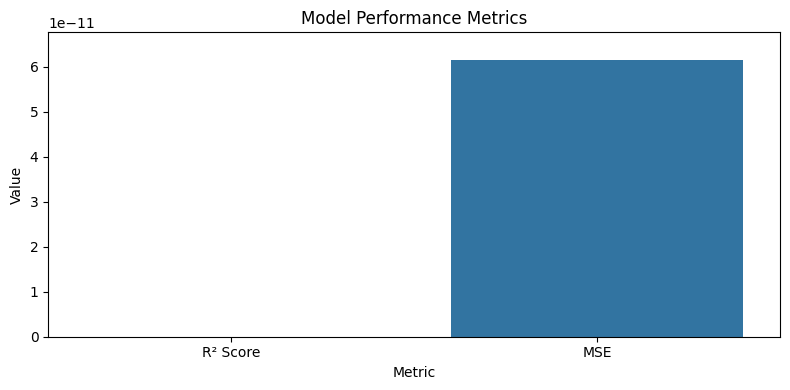

In [82]:
def plot_model_performance(r2_score, mse_score):
    metrics = pd.DataFrame({'Metric': ['R² Score', 'MSE'], 'Value': [r2_score, mse_score]})

    plt.figure(figsize=(8, 4))
    sns.barplot(x='Metric', y='Value', data=metrics)
    plt.title('Model Performance Metrics')
    plt.ylabel('Value')
    plt.ylim(0, max(mse_score, r2_score) + 0.1 * max(mse_score, r2_score))  # Adjust ylim for better visualization
    plt.tight_layout()
    plt.show()

# Assuming r2 and mse are already calculated
plot_model_performance(r2, mse)

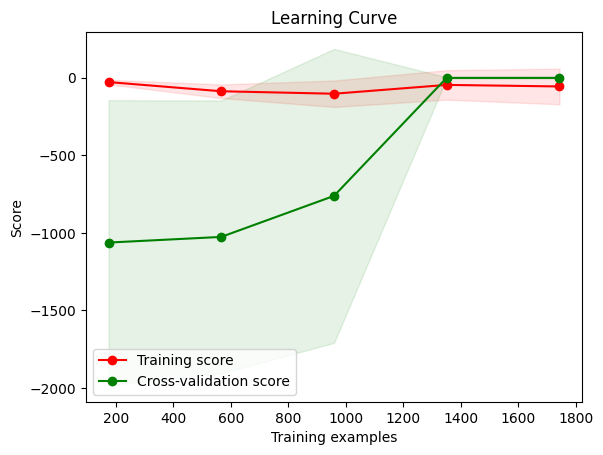

In [84]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(svm_model_rbf, X_train_scaled, y_train, n_jobs=-1, cv=5, train_sizes=np.linspace(.1, 1.0, 5))

# Calculate mean and standard deviation for train and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g", alpha=0.1)

plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.show()


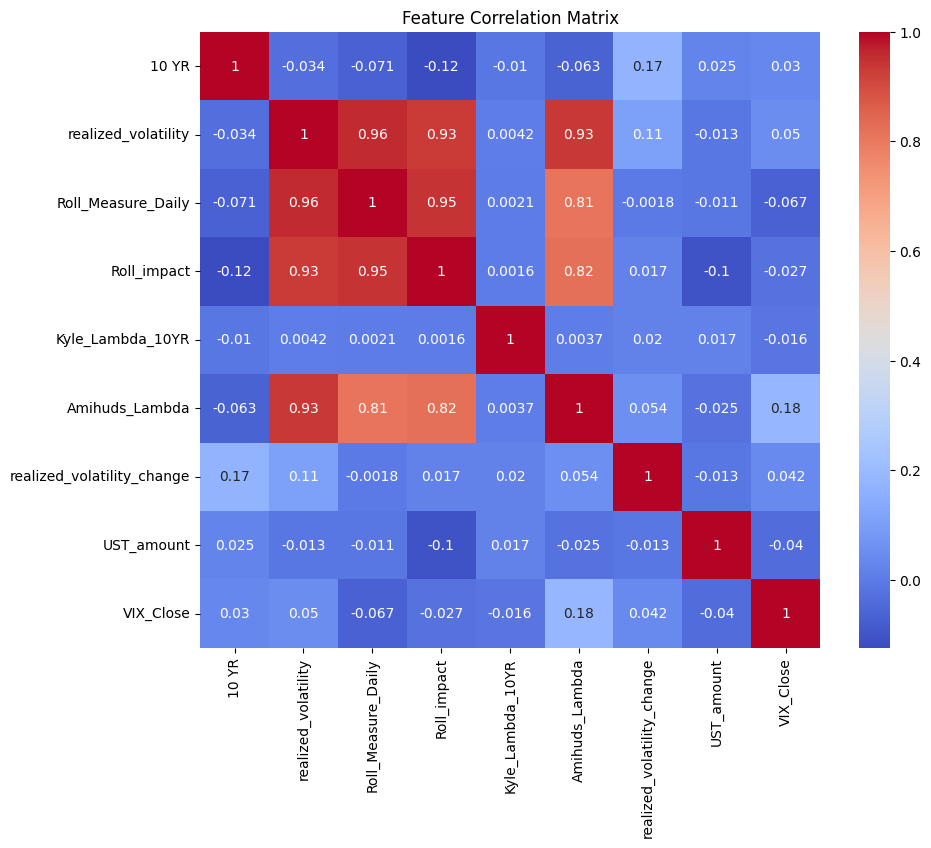

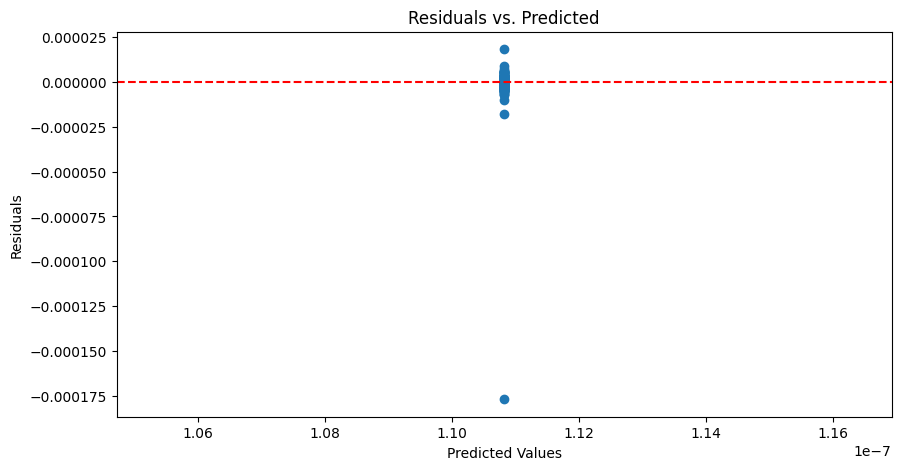

In [85]:
# Fit the model
svm_model_linear.fit(X_train, y_train)

# Predict on training and testing data
train_preds = svm_model_linear.predict(X_train)
test_preds = svm_model_linear.predict(X_test)

# Calculate and display the correlations
correlations = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# Assessing residuals
residuals = y_test - test_preds
plt.figure(figsize=(10, 5))
plt.scatter(test_preds, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted')
plt.show()

#### SVM Classification Model

In [109]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming 'price_changes_df' contains the necessary data
data = price_changes_df[['10 YR', 'realized_volatility', 'Roll_Measure_Daily', 'Roll_impact', 'Kyle_Lambda_10YR', 'Amihuds_Lambda', 'realized_volatility_change', 'UST_amount', 'VIX_Close']]
data.loc[:, 'realized_volatility_change_sign'] = np.sign(data['realized_volatility'].diff())

# Drop the first row since diff() will introduce a NaN
data.dropna(subset=['realized_volatility_change_sign'], inplace=True)

# Define the features and the target
features = ['Roll_Measure_Daily', 'Roll_impact', 'Kyle_Lambda_10YR', 'Amihuds_Lambda', 'VIX_Close']
X = data[features]
y = data['realized_volatility_change_sign'].astype(int)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = np.nan_to_num(X_train_scaled)
X_test_scaled = np.nan_to_num(X_test_scaled)

# Initialize and train the SVM with a linear kernel for feature selection
svm_model_linear = SVC(kernel='linear')
rfe = RFE(estimator=svm_model_linear, n_features_to_select=1, step=1)
rfe.fit(X_train_scaled, y_train)

# RFE results: ranks and selected features
print("Feature rankings:", rfe.ranking_)
print("Selected features mask:", rfe.support_)

# Train SVM with a linear kernel using the selected features
svm_model_linear = SVC(kernel='linear')
selected_features_train = X_train_scaled[:, rfe.support_]
selected_features_test = X_test_scaled[:, rfe.support_]
svm_model_linear.fit(selected_features_train, y_train)

feature_weights = svm_model_linear.coef_[0]
# Display feature names alongside their weights
for feature, weight in zip([features[i] for i in range(len(features)) if rfe.support_[i]], feature_weights):
    print(f"Feature: {feature}, Weight: {weight}")

# Predict and evaluate the model
y_pred = svm_model_linear.predict(selected_features_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)


<ipython-input-109-b6bd9ccb725f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'realized_volatility_change_sign'] = np.sign(data['realized_volatility'].diff())
<ipython-input-109-b6bd9ccb725f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=['realized_volatility_change_sign'], inplace=True)


Feature rankings: [2 3 5 1 4]
Selected features mask: [False False False  True False]
Feature: Amihuds_Lambda, Weight: 3.730217983388684e-07
Accuracy: 0.48807339449541287
Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       250
           0       0.00      0.00      0.00        29
           1       0.49      1.00      0.66       266

    accuracy                           0.49       545
   macro avg       0.16      0.33      0.22       545
weighted avg       0.24      0.49      0.32       545



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


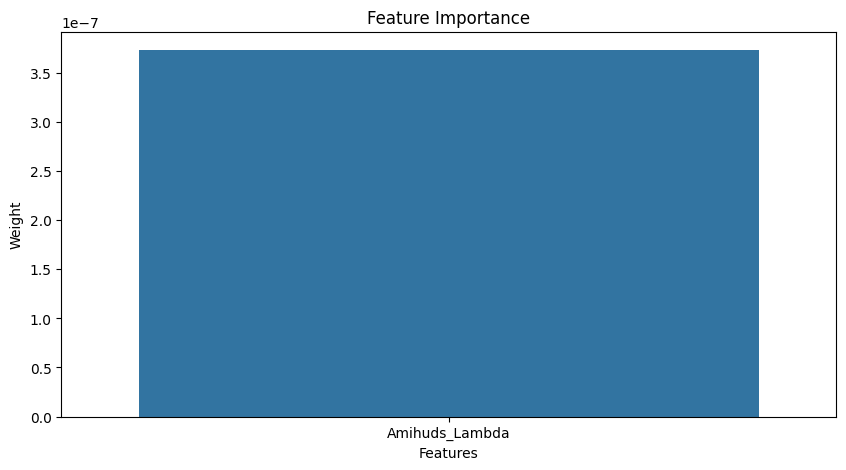

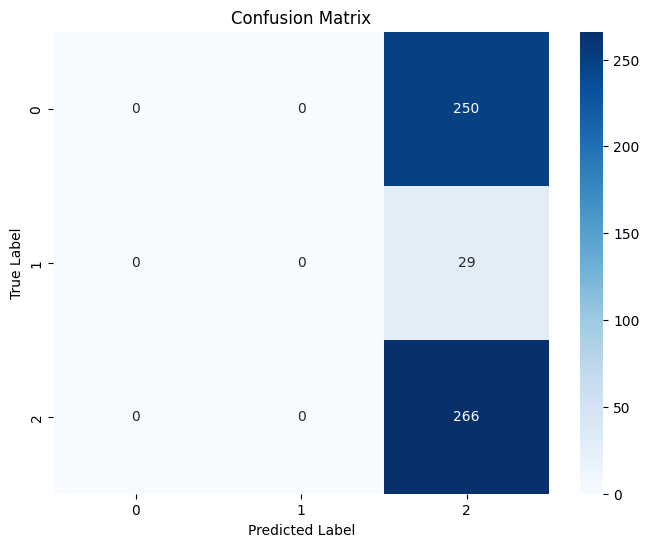

Accuracy: 0.48807339449541287
Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       250
           0       0.00      0.00      0.00        29
           1       0.49      1.00      0.66       266

    accuracy                           0.49       545
   macro avg       0.16      0.33      0.22       545
weighted avg       0.24      0.49      0.32       545



In [99]:
# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x=selected_features, y=feature_weights)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Weight')
plt.show()


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("Accuracy:", accuracy)
print("Classification Report:")
print(report)


##### Without RFE feature elimination

In [113]:
# Initialize the SVM with a linear kernel
svm_model_linear = SVC(kernel='linear', C=1.0)

# Train the SVM model using all scaled features
svm_model_linear.fit(X_train_scaled, y_train)

# Extract the coefficients (feature weights) if using a linear kernel
feature_weights = svm_model_linear.coef_[0]

# Display feature names alongside their weights
for feature, weight in zip(features, feature_weights):
    print(f"Feature: {feature}, Weight: {weight}")

# Predict and evaluate the model
y_pred = svm_model_linear.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Feature: Roll_Measure_Daily, Weight: 0.0007913369705443429
Feature: Roll_impact, Weight: 0.00015508025956201266
Feature: Kyle_Lambda_10YR, Weight: -0.0026169050565449936
Feature: Amihuds_Lambda, Weight: -0.00016305440328068244
Feature: VIX_Close, Weight: 8.551070754236889e-05
Accuracy: 0.44587155963302755
Classification Report:
              precision    recall  f1-score   support

          -1       0.45      0.75      0.56       250
           0       0.00      0.00      0.00        29
           1       0.45      0.21      0.29       266

    accuracy                           0.45       545
   macro avg       0.30      0.32      0.28       545
weighted avg       0.42      0.45      0.40       545



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


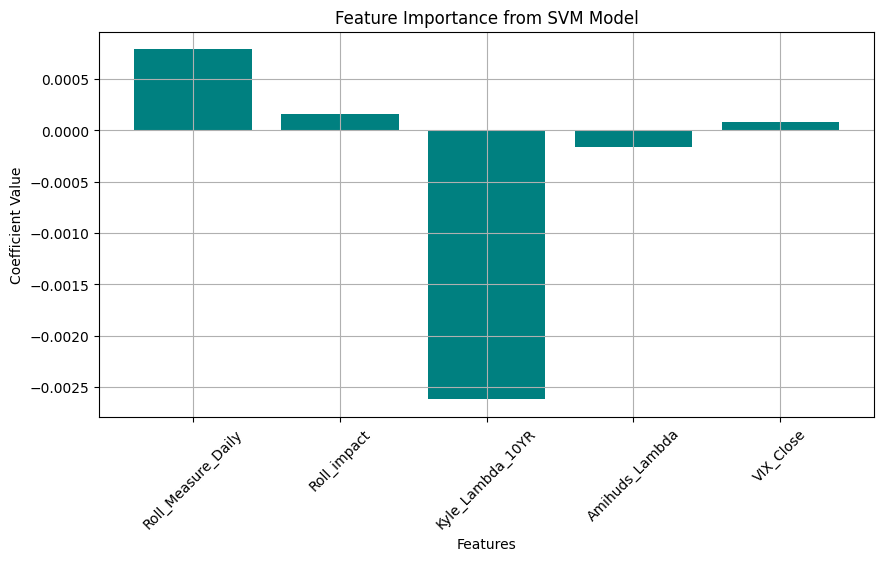

In [114]:
# Plotting the feature weights
plt.figure(figsize=(10, 5))
plt.bar(features, feature_weights, color='teal')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Feature Importance from SVM Model')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

##### SVM with RBF kernel

<ipython-input-106-0714eab6f0a4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'realized_volatility_change_sign'] = np.sign(data['realized_volatility'].diff())
<ipython-input-106-0714eab6f0a4>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=['realized_volatility_change_sign'], inplace=True)


Best parameters: {'C': 100, 'gamma': 1}
Best cross-validation score: 0.52
Test set accuracy with best parameters: 0.48
Classification Report:
              precision    recall  f1-score   support

          -1       0.47      0.60      0.53       250
           0       0.00      0.00      0.00        29
           1       0.51      0.43      0.47       266

    accuracy                           0.48       545
   macro avg       0.33      0.34      0.33       545
weighted avg       0.46      0.48      0.47       545



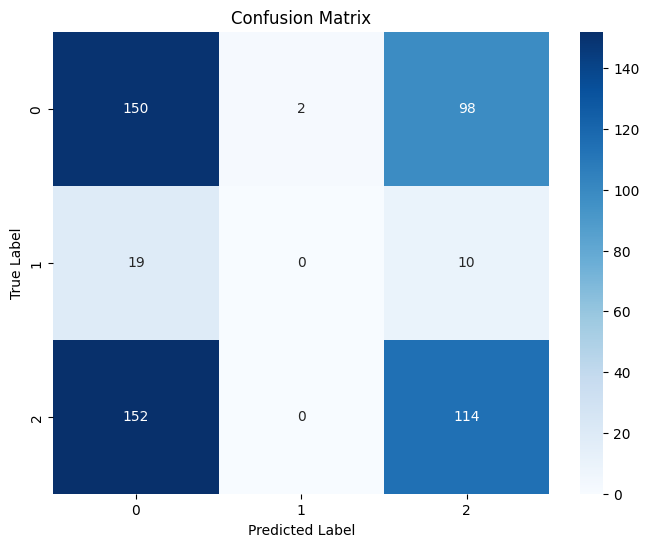

In [106]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming 'price_changes_df' contains the necessary data
data = price_changes_df[['10 YR', 'realized_volatility', 'Roll_Measure_Daily', 'Roll_impact', 'Kyle_Lambda_10YR', 'Amihuds_Lambda', 'realized_volatility_change', 'UST_amount', 'VIX_Close']]
data.loc[:, 'realized_volatility_change_sign'] = np.sign(data['realized_volatility'].diff())

# Drop the first row since diff() will introduce a NaN
data.dropna(subset=['realized_volatility_change_sign'], inplace=True)

# Define the features and the target
features = ['Roll_Measure_Daily', 'Roll_impact', 'Kyle_Lambda_10YR', 'Amihuds_Lambda', 'VIX_Close']
X = data[features]
y = data['realized_volatility_change_sign'].astype(int)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = np.nan_to_num(X_train_scaled)
X_test_scaled = np.nan_to_num(X_test_scaled)

# SVM Model with RBF kernel and GridSearch for parameter tuning
parameters = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Kernel coefficient for 'rbf'
}
svm_rbf = SVC(kernel='rbf')
grid_search = GridSearchCV(svm_rbf, parameters, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Train SVM with the best parameters found
best_svm_rbf = grid_search.best_estimator_
y_pred = best_svm_rbf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Evaluation output
print("Test set accuracy with best parameters: {:.2f}".format(accuracy))
print("Classification Report:")
print(report)

# Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


#### Random Forest

In [91]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Calculate the sign of change in realized volatility
# Assuming the column 'realized_volatility' exists in your DataFrame
data = price_changes_df[['10 YR', 'realized_volatility', 'Roll_Measure_Daily', 'Roll_impact', 'Kyle_Lambda_10YR', 'Amihuds_Lambda', 'realized_volatility_change', 'UST_amount', 'VIX_Close']]  # Using the DataFrame directly
data['realized_volatility_change_sign'] = np.sign(data['realized_volatility'].diff())

# Drop the first row since diff() will introduce a NaN
data.dropna(subset=['realized_volatility_change_sign'], inplace=True)

# Define the features and the new binary target
features = ['Roll_Measure_Daily', 'Roll_impact', 'Kyle_Lambda_10YR', 'Amihuds_Lambda', 'VIX_Close']
X = data[features]
y = data['realized_volatility_change_sign'].astype(int)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = np.nan_to_num(X_train_scaled)
X_test_scaled = np.nan_to_num(X_test_scaled)

# Initialize and train the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Feature importances
feature_importances = rf_model.feature_importances_
print("Feature Importances:")
for feature, importance in zip(features, feature_importances):
    print(f"{feature}: {importance}")

# Predict and evaluate the model
y_pred = rf_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(report)


<ipython-input-91-52cdeb7ab729>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['realized_volatility_change_sign'] = np.sign(data['realized_volatility'].diff())
<ipython-input-91-52cdeb7ab729>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=['realized_volatility_change_sign'], inplace=True)


Feature Importances:
Roll_Measure_Daily: 0.19483649598585306
Roll_impact: 0.1964911678337247
Kyle_Lambda_10YR: 0.2139093051683246
Amihuds_Lambda: 0.19926991187378743
VIX_Close: 0.19549311913831027
Accuracy: 0.5247706422018349
Classification Report:
              precision    recall  f1-score   support

          -1       0.51      0.51      0.51       250
           0       0.00      0.00      0.00        29
           1       0.54      0.60      0.57       266

    accuracy                           0.52       545
   macro avg       0.35      0.37      0.36       545
weighted avg       0.50      0.52      0.51       545



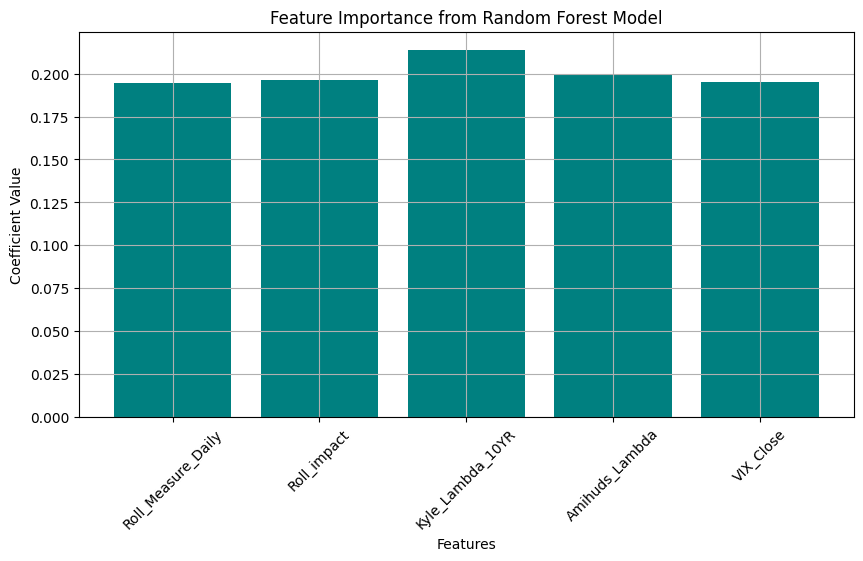

In [116]:
# Plotting the feature weights
plt.figure(figsize=(10, 5))
plt.bar(features, feature_importances, color='teal')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Feature Importance from Random Forest Model')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Old code

In [ ]:
def split_dataframe(df, table_prefix):
    # Find the indices of columns that contain "Unnamed"
    unnamed_indices = [index for index, col in enumerate(df.columns) if 'Unnamed' in col]

    # Define the suffixes for the table names
    table_suffixes = ['amount', 'percent_of_total', 'year_over_year_change', 'quarter_over_quarter_change']
    table_names = [f'{table_prefix}_{suffix}' for suffix in table_suffixes]

    # Dictionary to hold the tables
    tables = {}

    # Extract the tables using the unnamed_indices
    # Start with the index after the first 'Unnamed' column
    start_idx = unnamed_indices[0] + 1
    for i, end_idx in enumerate(unnamed_indices[1:]):
        # The end index is the next 'Unnamed' column
        tables[table_names[i]] = df.iloc[:, start_idx:end_idx].dropna(axis=1, how='all')
        start_idx = end_idx + 1

    # The last table includes all remaining columns after the last 'Unnamed' column
    tables[table_names[-1]] = df.iloc[:, start_idx:].dropna(axis=1, how='all')

    return tables



In [ ]:

# Assuming 'outstanding' is your DataFrame
table_prefix = 'fi_outstanding'
tables = split_dataframe(outstanding, table_prefix)

for table in tables.values():
  for column in table.columns:
    if column.endswith(".1"):
      table.rename(columns={column: column[:-2]}, inplace=True)
    elif column.endswith(".2"):
      table.rename(columns={column: column[:-2]}, inplace=True)
    elif column.endswith(".3"):
      table.rename(columns={column: column[:-2]}, inplace=True)
    elif column.endswith(".4"):
      table.rename(columns={column: column[:-2]}, inplace=True)

# Access the tables by their names
fi_outstanding_amount = tables['fi_outstanding_amount']
fi_outstanding_percent_of_total = tables['fi_outstanding_percent_of_total']
fi_outstanding_year_over_year_change = tables['fi_outstanding_year_over_year_change']
fi_outstanding_quarter_over_quarter_change = tables['fi_outstanding_quarter_over_quarter_change']

In [ ]:
# Extract the year column from the original DataFrame
year = outstanding['Unnamed: 0'].astype(str)

# Add the year column to each table
for table in tables.values():
    table.insert(0, 'year', year)


In [ ]:
# prompt: drop the 11th row

tables['fi_outstanding_amount'].drop(11, inplace=True)
tables['fi_outstanding_percent_of_total'].drop(11, inplace=True)
tables['fi_outstanding_year_over_year_change'].drop(11, inplace=True)
tables['fi_outstanding_quarter_over_quarter_change'].drop(11, inplace=True)


In [144]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Create an instance of SimpleImputer
imputer = SimpleImputer(strategy='mean')

# Impute missing values in the entire DataFrame
price_changes_df_imputed = pd.DataFrame(imputer.fit_transform(price_changes_df),
                                        columns=price_changes_df.columns)

# Extract the relevant columns from the imputed DataFrame
X = price_changes_df_imputed[['Roll_Measure_Daily', 'Roll_impact', 'Kyle_Lambda_10YR', 'Amihuds_Lambda']].values
y = price_changes_df_imputed['Synthetic_Volatility'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svm_model.fit(X_train_scaled, y_train)

y_pred = svm_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.00010984987326765418
R-squared: -0.003443376790789321


### EDA

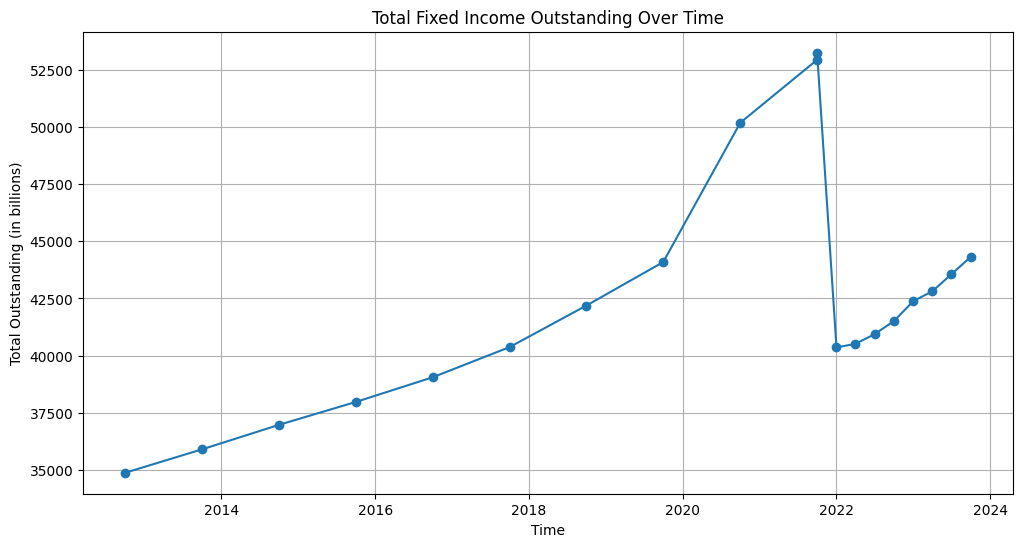

In [ ]:
def normalize_date(date_str):
    if pd.isna(date_str):
        return pd.NaT  # Use pandas NaT for missing time data
    if 'Q' in date_str:
        # Convert e.g., '4Q21' to '2021Q4'
        year_part = date_str[-2:]
        quarter_part = date_str[-4]  # Get the quarter part
        date_str = f"20{year_part}Q{quarter_part}"
    else:
        # For full years, assume data corresponds to Q4
        date_str = f"{date_str}Q4"
    return pd.Period(date_str, freq='Q')

# Apply the normalization function to the Date column
fi_outstanding_amount['year'] = fi_outstanding_amount['year'].apply(normalize_date)

# Now plot the total outstanding amounts over the years and quarters
plt.figure(figsize=(12, 6))
plt.plot(fi_outstanding_amount['year'].dt.to_timestamp(), fi_outstanding_amount['Total'], marker='o')
plt.title('Total Fixed Income Outstanding Over Time')
plt.xlabel('Time')
plt.ylabel('Total Outstanding (in billions)')
plt.grid(True)
plt.show()

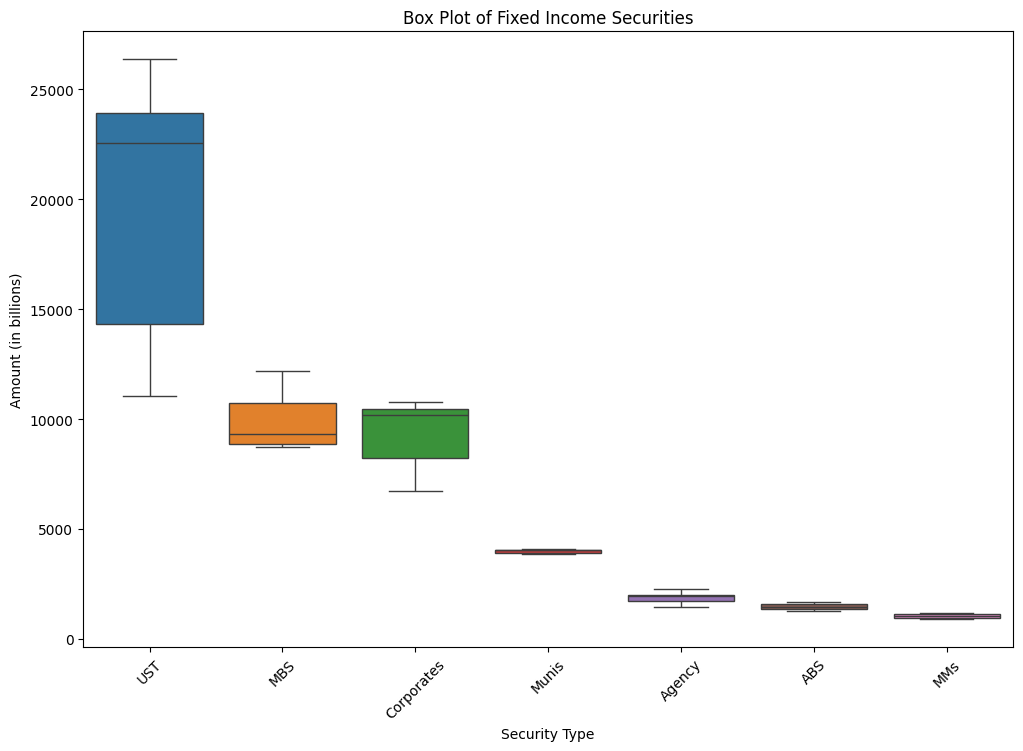

In [ ]:
# Using box plots to visualize outliers for each type of security
plt.figure(figsize=(12, 8))
sns.boxplot(data=fi_outstanding_amount.iloc[:, 1:-1])  # Skip 'Date' and 'Total'
plt.title('Box Plot of Fixed Income Securities')
plt.xlabel('Security Type')
plt.ylabel('Amount (in billions)')
plt.xticks(rotation=45)
plt.show()

In [ ]:
fi_outstanding_percent_of_total

,year,UST,MBS,Corporates,Munis,Agency,ABS,MMs
0,2012,0.316739,0.253426,0.192519,0.113199,0.060096,0.036713,0.027308
1,2013,0.330217,0.243534,0.198352,0.108237,0.057336,0.035815,0.026509
2,2014,0.338248,0.239172,0.201911,0.104126,0.054877,0.036500,0.025166
3,2015,0.347408,0.234251,0.202835,0.101909,0.052550,0.036253,0.024795
4,2016,0.356136,0.231049,0.203689,0.100343,0.050487,0.035638,0.022658
5,2017,0.358379,0.230465,0.205734,0.097465,0.047920,0.036111,0.023925
6,2018,0.369932,0.230670,0.201659,0.092192,0.043648,0.038293,0.023606
7,2019,0.378115,0.231983,0.200904,0.088431,0.039145,0.037718,0.023704
8,2020,0.417857,0.223423,0.195450,0.079373,0.033643,0.030592,0.019662
9,2021,0.426547,0.230453,0.189974,0.076860,0.027071,0.029941,0.019155


### Feature Engineering

#### Yearly Change Rate, Quarterly Change Rate

In [ ]:
# Calculate relative changes as new features
# For yearly change
fi_outstanding_amount['Yearly_Change'] = fi_outstanding_year_over_year_change['Total']

# For quarterly change
fi_outstanding_amount['Quarterly_Change'] = fi_outstanding_quarter_over_quarter_change['Total']

# Normalize the changes by dividing by the amount (to get a rate of change)
fi_outstanding_amount['Yearly_Change_Rate'] = fi_outstanding_amount['Yearly_Change'] / fi_outstanding_amount['Total']
fi_outstanding_amount['Quarterly_Change_Rate'] = fi_outstanding_amount['Quarterly_Change'] / fi_outstanding_amount['Total']

# Replace infinite values and NaNs that might occur during division
fi_outstanding_amount.replace([np.inf, -np.inf], np.nan, inplace=True)
fi_outstanding_amount.fillna(0, inplace=True)

# Now you can use 'Yearly_Change_Rate' and 'Quarterly_Change_Rate' as features in your SVM model


In [ ]:
fi_outstanding_amount['Future_Total'] = fi_outstanding_amount['Total'].shift(-1)
correlation = fi_outstanding_amount['Yearly_Change_Rate'].corr(fi_outstanding_amount['Future_Total'])
print(f"The correlation coefficient between the yearly change rate and future total outstanding is: {correlation}")


The correlation coefficient between the yearly change rate and future total outstanding is: 0.010930415968651573


In [ ]:
# Calculate yearly change rates for each type of security
for security_type in ['UST', 'Corporates', 'Munis', 'Agency', 'MMs']:
    fi_outstanding_amount[f'Yearly_Change_Rate_{security_type}'] = (
        fi_outstanding_year_over_year_change[security_type] / fi_outstanding_amount[security_type]
    )

# Normalize the changes by dividing by the amount (to get a rate of change)
for security_type in ['UST', 'Corporates', 'Munis', 'Agency', 'MMs']:
    fi_outstanding_amount[f'Yearly_Change_Rate_{security_type}'] = fi_outstanding_amount[f'Yearly_Change_Rate_{security_type}'] / fi_outstanding_amount['Total']

# Replace infinite values and NaNs that might occur during division
fi_outstanding_amount.replace([np.inf, -np.inf], np.nan, inplace=True)
fi_outstanding_amount.fillna(0, inplace=True)

# Now you can use the security-specific yearly change rates as features in your SVM model


In [ ]:
# Calculate the correlation coefficient for each security
correlations = {}
for security_type in ['UST', 'Corporates', 'Munis', 'Agency', 'MMs']:
    correlations[security_type] = fi_outstanding_amount[f'{security_type}_Yearly_Change_Rate'].corr(fi_outstanding_amount['Future_Total'])

# Print the correlations
for security_type, correlation in correlations.items():
    print(f"The correlation coefficient between the yearly change rate of {security_type} and future total outstanding is: {correlation}")


The correlation coefficient between the yearly change rate of UST and future total outstanding is: 0.0524622053880103
The correlation coefficient between the yearly change rate of Corporates and future total outstanding is: 0.08686958986160848
The correlation coefficient between the yearly change rate of Munis and future total outstanding is: -0.25438483932313416
The correlation coefficient between the yearly change rate of Agency and future total outstanding is: 0.24584003943016078
The correlation coefficient between the yearly change rate of MMs and future total outstanding is: -0.01818997437788838


In [ ]:
for security_type in ['UST', 'Corporates', 'Munis', 'Agency', 'MMs']:
    fi_outstanding_amount[f'Quarterly_Change_Rate_{security_type}'] = (
        fi_outstanding_quarter_over_quarter_change[security_type] / fi_outstanding_amount[security_type]
    )

# Normalize the changes by dividing by the amount (to get a rate of change)
for security_type in ['UST', 'Corporates', 'Munis', 'Agency', 'MMs']:
    fi_outstanding_amount[f'Quarterly_Change_Rate_{security_type}'] = fi_outstanding_amount[f'Quarterly_Change_Rate_{security_type}'] / fi_outstanding_amount['Total']

# Replace infinite values and NaNs that might occur during division
fi_outstanding_amount.replace([np.inf, -np.inf], np.nan, inplace=True)
fi_outstanding_amount.fillna(0, inplace=True)

# Now you can use the security-specific quarterly change rates as features in your SVM model

# Calculate the correlation coefficient for each security
correlations = {}
for security_type in ['UST', 'Corporates', 'Munis', 'Agency', 'MMs']:
    correlations[security_type] = fi_outstanding_amount[f'Quarterly_Change_Rate_{security_type}'].corr(fi_outstanding_amount['Future_Total'])

# Print the correlations
for security_type, correlation in correlations.items():
    print(f"The correlation coefficient between the quarterly change rate of {security_type} and future total outstanding is: {correlation}")


The correlation coefficient between the quarterly change rate of UST and future total outstanding is: -0.0897487822158203
The correlation coefficient between the quarterly change rate of Corporates and future total outstanding is: -0.25260699602440884
The correlation coefficient between the quarterly change rate of Munis and future total outstanding is: -0.22598000158193013
The correlation coefficient between the quarterly change rate of Agency and future total outstanding is: 0.11302388622400432
The correlation coefficient between the quarterly change rate of MMs and future total outstanding is: 0.012866300850244454


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
change_rates = fi_outstanding_amount[['Yearly_Change_Rate_UST', 'Yearly_Change_Rate_Corporates', 'Yearly_Change_Rate_Munis', 'Yearly_Change_Rate_Agency', 'Yearly_Change_Rate_MMs',
                   'Quarterly_Change_Rate_UST', 'Quarterly_Change_Rate_Corporates', 'Quarterly_Change_Rate_Munis', 'Quarterly_Change_Rate_Agency', 'Quarterly_Change_Rate_MMs']]
change_rates_scaled = scaler.fit_transform(change_rates)

# Apply PCA
pca = PCA(n_components=2)  # Adjust components as needed
principal_components = pca.fit_transform(change_rates_scaled)
fi_outstanding_amount['PCA_Feature1'] = principal_components[:, 0]
fi_outstanding_amount['PCA_Feature2'] = principal_components[:, 1]

# Create interaction features for Agency and Corporates as an example
fi_outstanding_amount['Interaction_Agency_Corp_Y'] = fi_outstanding_amount['Yearly_Change_Rate_Agency'] * fi_outstanding_amount['Yearly_Change_Rate_Corporates']
fi_outstanding_amount['Interaction_Agency_Corp_Q'] = fi_outstanding_amount['Quarterly_Change_Rate_Agency'] * fi_outstanding_amount['Quarterly_Change_Rate_Corporates']

# Non-linear transformations
fi_outstanding_amount['Yearly_Change_Rate_UST_Squared'] = fi_outstanding_amount['Yearly_Change_Rate_UST'] ** 2
fi_outstanding_amount['Quarterly_Change_Rate_Corporates_Sqrt'] = np.sqrt(fi_outstanding_amount['Quarterly_Change_Rate_Corporates'].abs())

# Diffusion Index
fi_outstanding_amount['Diffusion_Index'] = fi_outstanding_amount[['Yearly_Change_Rate_UST', 'Yearly_Change_Rate_Corporates', 'Yearly_Change_Rate_Munis', 'Yearly_Change_Rate_Agency', 'Yearly_Change_Rate_MMs']].gt(0).sum(axis=1) / 5

,year,UST,MBS,Corporates,Munis,Agency,ABS,MMs
0,2012,0.316739,0.253426,0.192519,0.113199,0.060096,0.036713,0.027308
1,2013,0.330217,0.243534,0.198352,0.108237,0.057336,0.035815,0.026509
2,2014,0.338248,0.239172,0.201911,0.104126,0.054877,0.036500,0.025166
3,2015,0.347408,0.234251,0.202835,0.101909,0.052550,0.036253,0.024795
4,2016,0.356136,0.231049,0.203689,0.100343,0.050487,0.035638,0.022658
5,2017,0.358379,0.230465,0.205734,0.097465,0.047920,0.036111,0.023925
6,2018,0.369932,0.230670,0.201659,0.092192,0.043648,0.038293,0.023606
7,2019,0.378115,0.231983,0.200904,0.088431,0.039145,0.037718,0.023704
8,2020,0.417857,0.223423,0.195450,0.079373,0.033643,0.030592,0.019662
9,2021,0.426547,0.230453,0.189974,0.076860,0.027071,0.029941,0.019155
